# Perform a simulation with ModularSimulator with propeller and semi empirical rudder model

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [87]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system


import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/08/23 10:40:16] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=252650;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=657452;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/08/23 10:40:24] INFO     Kedro project phd                                                      ]8;id=851170;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=137193;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=716141;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=576506;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=534414;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=675206;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=292434;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692006;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=62941;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=854454;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=490969;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=118475;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=885597;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=756227;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=66720;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=9925;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[06/08/23 10:40:25] INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=48694;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659179;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
#fx_eq = fx_eq.subs(X_D,X_D_)
#fy_eq = fy_eq.subs(Y_D,Y_D_)
#mz_eq = mz_eq.subs(N_D,N_D_)

f_X_H = sp.Function('X_H')(u,v,r,delta)
f_Y_H = sp.Function('Y_H')(u,v,r,delta)
f_N_H = sp.Function('N_H')(u,v,r,delta)

f_X_R = sp.Function('X_R')(u,v,r,delta,thrust)
f_Y_R = sp.Function('Y_R')(u,v,r,delta,thrust)
f_N_R = sp.Function('N_R')(u,v,r,delta,thrust)

f_X_P = sp.Function('X_P')(u,v,r,rev)

eq_X_force = fx_eq.subs(X_D, f_X_H + f_X_R + f_X_P)
eq_Y_force = fy_eq.subs(Y_D, f_Y_H + f_Y_R)
eq_N_force = mz_eq.subs(N_D, f_N_H + f_N_R)

X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_H(u, v, r, delta) + X_P(u, v, r, rev) + X_R(u, v, r, delta, thrust))

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_H(u, v, r, delta) + Y_R(u, v, r, delta, thrust))

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v} + N_H(u, v, r, delta) + N_R(u, v, r, delta, thrust))

In [6]:
model_old= model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [113]:
parameters = dict(model_old.parameters)
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}
parameters.update(params)
g_=9.81
parameters['g'] = g_

rudder_particulars = {
'x_R'   : ship_data['x_r'],
'y_R'   : 0,
'z_R'   : 0,
'A_R'   : 70/(ship_data['scale_factor']**2),
'b_R'   : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f'   :ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}

rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(40),
"kappa": 0.5, # (Small value means much flow straightening)
"nu":1.18849E-06,
}
parameters.update(rudder_parameters)

ship_parameters = ship_data.copy()
ship_parameters.update(rudder_particulars)
ship_parameters.update(prop_data)


In [8]:
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=parameters, 
                               control_keys=['delta','rev'], do_create_jacobian=False)

## Add thrust prediction model

In [9]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

In [10]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [11]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

Assuming that $w_{p0}$ is a good model:

In [12]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [13]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)
eq = sp.Eq(thrust,n_prop*solution[0][thrust_propeller])
eq

Eq(thrust, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [14]:
eq_X_P = sp.Eq(X_P, p.Xthrust*thrust)

In [15]:
propeller_equations = [eq, eq_X_P]
propellers = EquationSubSystem(ship=model, equations=propeller_equations, create_jacobians=False)
model.subsystems['propellers'] = propellers

## Add semi-empirical rudder

In [16]:
rudders = SemiempiricalRudderSystem(ship=model, create_jacobians=False)
model.subsystems['rudders'] = rudders

## Add hull

In [17]:
eq_X_H = model_old.X_qs_eq.subs([
(X_D, X_H,),
(thrust,0),
])

eq_Y_H = model_old.Y_qs_eq.subs([
(Y_D, Y_H,),
(delta,0),
])

eq_N_H = model_old.N_qs_eq.subs([
(N_D, N_H,),
(delta,0),
])

display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)


Eq(X_H, X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{r}*r + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_H, N_{r}*r + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{v}*v)

In [18]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull, create_jacobians=False)
model.subsystems['hull'] = hull

## Resimulate

In [19]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [20]:
data_ = data.drop(columns=['thrust'])
result = model.simulate(data_)

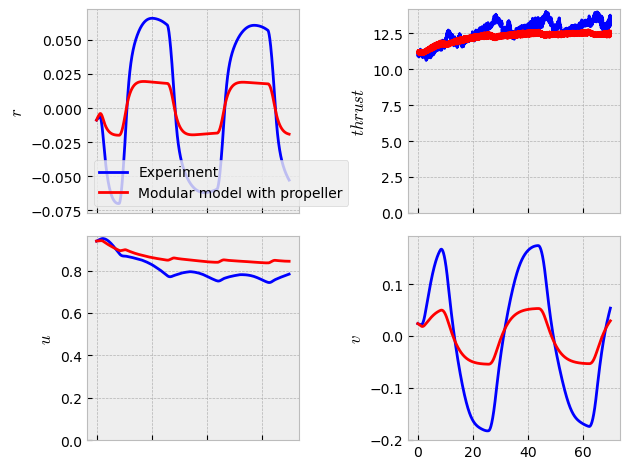

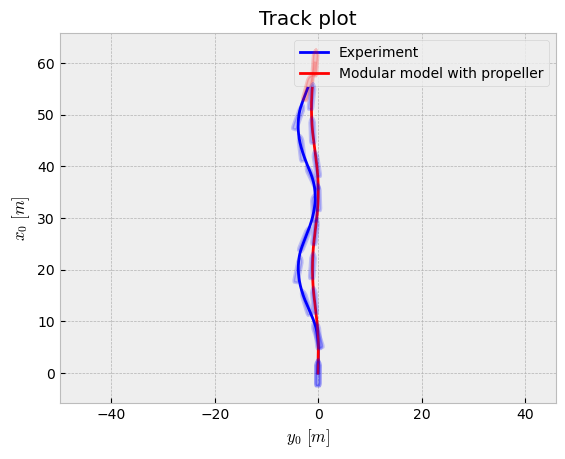

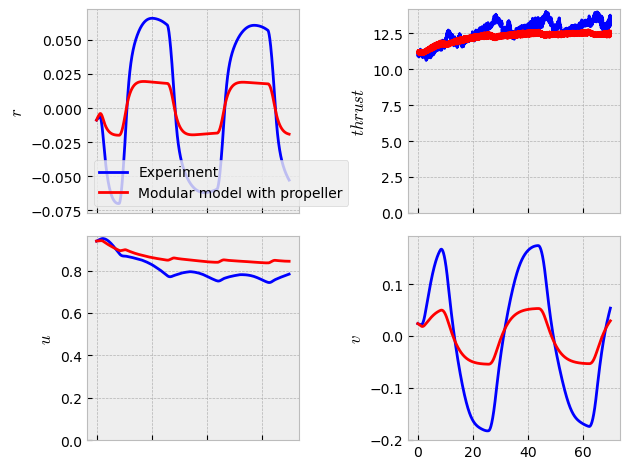

In [21]:
dataframes = {
              'Experiment':data,
              'Modular model with propeller':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust'])

In [22]:
model.Y_eq

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_H(u, v, r, delta) + Y_R(u, v, r, delta, thrust))

In [23]:
model.Y_D_eq

Eq(Y_D, Y_H(u, v, r, delta) + Y_R(u, v, r, delta, thrust))

In [24]:
sp.Eq(Y_D,sp.solve(model.Y_eq.subs(model.Y_D_eq.rhs, model.Y_D_eq.lhs), Y_D_)[0])

Eq(Y_D(u, v, r, delta, thrust), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

In [26]:
model.forces_from_motions(data=data)

,x0,y0,psi,u,v,r,Prop/PS/Torque,roll,v1d,z0,Prop/SB/Rpm,Prop/PS/Thrust,thrust,Wind/Course,Prop/PS/Rpm,U,Wind/CourseTreshold,delta,V,r1d,Prop/SB/Thrust,Prop/SB/Torque,u1d,pitch,rev,fx,fy,mz
0.000000,-0.002863,-0.037007,0.007873,0.939222,0.023695,-0.008880,-0.115821,0.001138,-0.002251,0.002467,9.590799,5.505012,11.192494,6.282836,9.569964,0.939521,1.0,-0.000007,0.939521,0.002682,5.687483,0.111180,0.007124,0.000295,9.580381,3.154278,-5.281059,3.037860
0.010000,0.006529,-0.036711,0.007784,0.939293,0.023673,-0.008853,-0.116216,0.001158,-0.002254,0.002405,9.541293,5.555121,11.226566,6.282836,9.628717,0.939592,1.0,-0.000014,0.939592,0.002677,5.671445,0.108954,0.007161,-0.000311,9.585005,3.170093,-5.272762,3.031917
0.020000,0.015922,-0.036415,0.007696,0.939365,0.023650,-0.008826,-0.114932,0.001134,-0.002258,0.002487,9.556246,5.633792,11.233630,6.282836,9.603547,0.939663,1.0,-0.000014,0.939663,0.002667,5.599838,0.105735,0.007205,0.000372,9.579897,3.188568,-5.266734,3.019691
0.030000,0.025316,-0.036121,0.007607,0.939438,0.023628,-0.008800,-0.112320,0.001152,-0.002262,0.002469,9.540091,5.710973,11.198602,6.282836,9.572272,0.939735,1.0,-0.000014,0.939735,0.002656,5.487629,0.102544,0.007169,-0.000409,9.556182,3.172491,-5.260265,3.007100
0.040000,0.034710,-0.035827,0.007519,0.939509,0.023605,-0.008773,-0.109036,0.001127,-0.002266,0.002443,9.560101,5.755025,11.119227,6.282836,9.564290,0.939805,1.0,-0.000014,0.939805,0.002646,5.364202,0.100559,0.007032,0.000531,9.562195,3.113196,-5.253510,2.994510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69.780004,55.137877,-2.020584,0.267769,0.783231,0.052728,-0.052844,-0.122150,0.003292,0.020669,0.001898,9.567492,6.221050,13.471503,0.264592,9.462708,0.785004,1.0,0.349065,0.785004,-0.003648,7.250453,0.137168,0.005885,0.000757,9.515100,3.757908,-1.526047,-3.417657
69.790004,55.145291,-2.018003,0.267241,0.783288,0.052934,-0.052880,-0.126552,0.003352,0.020636,0.001802,9.559078,6.107276,13.269078,0.263632,9.529382,0.785074,1.0,0.349078,0.785074,-0.003613,7.161802,0.134628,0.005421,0.000008,9.544230,3.564045,-1.564053,-3.378532
69.800004,55.152706,-2.015424,0.266712,0.783340,0.053140,-0.052916,-0.131896,0.003351,0.020604,0.001847,9.548417,6.066484,13.116171,0.263545,9.557123,0.785140,1.0,0.349078,0.785140,-0.003581,7.049687,0.132942,0.004998,0.000907,9.552770,3.387983,-1.600658,-3.342127
69.810004,55.160122,-2.012847,0.266183,0.783388,0.053346,-0.052951,-0.136197,0.003415,0.020579,0.001764,9.582675,6.110756,13.062099,0.263021,9.606425,0.785202,1.0,0.349065,0.785202,-0.003557,6.951343,0.132698,0.004748,-0.000148,9.594550,3.286230,-1.632889,-3.315713


In [102]:
eq_f_Y_H = sp.Eq(f_Y_H, sp.solve(model.Y_eq, f_Y_H)[0])
#u_prime, v_prime = sp.symbols("u' v'")
#eq_f_Y_H = eq_f_Y_H.subs(
#                [
#                    (
#                        u,
#                        u_prime,
#                    ),  # u_prime and u as a denominator needs to be distinguished,
#                    # so that the denominator is not applied twice for r etc.
#                    (v, v_prime),
#                ]
#            )
#
subs_prime = [
    (f_X_R,f_X_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
    (f_Y_R,f_Y_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
    (f_N_R,f_N_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**3)),
    (f_X_P,f_X_P/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#    (m, m / prime_system.df_prime.mass.denominator),
#    (I_z, I_z / prime_system.df_prime.inertia_moment.denominator),
#    (x_G, x_G / prime_system.df_prime.length.denominator),
#    (u_prime, u / sp.sqrt(u**2 + v**2)),
#    (v_prime, v / sp.sqrt(u**2 + v**2)),
#    (r, r / (sp.sqrt(u**2 + v**2) / L)),
#    
]
eq_f_Y_H = eq_f_Y_H.subs(subs_prime)

In [103]:
eq_f_Y_H

Eq(Y_H(u, v, r, delta), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u - 2*Y_R(u, v, r, delta, thrust)/(L**2*rho*(u**2 + v**2)))

In [104]:
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
lambda_f_Y_H = lambdify(eq_f_Y_H.rhs.subs(subs_simpler), substitute_functions=True)

In [105]:
lambda_f_Y_H

<function _lambdifygenerated(L, Y_R, Yrdot, Yvdot, m, r, r1d, rho, u, v, v1d, x_G)>

In [106]:

states_str = [str(state.subs(subs_simpler)).replace('_','') for state in model.states]
states_str

['x0', 'y0', 'psi', 'u', 'v', 'r']

In [107]:
calculation = model.calculate_forces(states_dict=data[states_str], control=data[model.control_keys])

In [94]:
calculation.keys()

dict_keys(['thrust', 'X_P', 'V_x', 'C_L', 'X_R', 'Y_R', 'N_R', 'X_H', 'Y_H', 'N_H', 'X_D', 'Y_D', 'N_D'])

In [112]:
data_prime = model.prime_system.prime(data[states_str+['u1d','v1d','r1d']], U=data['U'])
run(lambda_f_Y_H, inputs=data_prime, **calculation, **model.ship_parameters_prime, **model.parameters)

0.000000     0.641395
0.010000     0.640331
0.020000     0.639133
0.030000     0.637937
0.040000     0.636744
               ...   
69.780004   -2.587192
69.790004   -2.585693
69.800004   -2.584025
69.810004   -2.582192
69.820004   -2.580638
Length: 6983, dtype: float64